Context
My friends and I are creating an open source prosthetic control system which would enable prosthetic devices to have multiple degrees of freedom. https://github.com/cyber-punk-me

The system is built of several components. It connects a muscle activity (EMG, Electromyography) sensor to a user Android/Android Things App. The app collects data, then a server builds a Tensorflow model specifically for this user. After that the model can be downloaded and executed on the device to control motors or other appendages.

This dataset can be used to map user residual muscle gestures to certain actions of a prosthetic such as open/close hand or rotate wrist.

For a reference please watch a video on this topic : Living with a mind-controlled robot arm

Content
Four classes of motion were written from MYO armband with the help of our app https://github.com/cyber-punk-me/nukleos. The MYO armband has 8 sensors placed on skin surface, each measures electrical activity produced by muscles beneath.

Each dataset line has 8 consecutive readings of all 8 sensors. so 64 columns of EMG data. The last column is a resulting gesture that was made while recording the data (classes 0-3) So each line has the following structure:

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]
Data was recorded at 200 Hz, which means that each line is 40ms of record time.

A classifier given 64 numbers would predict a gesture class (0-3). Gesture classes were : rock - 0, scissors - 1, paper - 2, ok - 3.

Inspiration
Be one of the real cyber punks inventing electronic appendages. Let's help people who really need it. There's a lot of work and cool stuff ahead =)

Main goals of this sheet are:
- extract features
- compare predictive models


In [384]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [33]:
sensors = [('S' + str(i)) for i in range(1,9)]
columns = [ i + '_' + str(j) for j in range (1,9) for i in sensors]



In [6]:
data0 = pd.read_csv('0.csv', header=None, names=columns, index_col=False)
data1 = pd.read_csv('1.csv', header=None, names=columns, index_col=False)
data2 = pd.read_csv('2.csv', header=None, names=columns, index_col=False)
data3 = pd.read_csv('3.csv', header=None, names=columns, index_col=False)
data = pd.concat([data0, data1, data2, data3], axis=0)
data = data.reset_index()
data = data.drop('index', axis =1)

# 'Sx_y'
- x - represents a sensor 
- y - represents a number of measurement in time, I assumed that y=1 happend before y = 2

Plots represents values of EMG for each sensor in time.

In [ ]:
sensor_groups = [ [i + '_' + str(j) for j in range (1,9)] for i in sensors]

dict_columns_to_sensor = dict(zip(sensors, sensor_groups))

In [150]:
def plot_sensors_values(data, nr, plot_type=sns.scatterplot):
    
    S1 = data.loc[:,dict_columns_to_sensor['S1']]
    #S1.iloc[0:10,:]#.index[0:10]
    S2 = data.loc[:,dict_columns_to_sensor['S2']]
    S3 = data.loc[:,dict_columns_to_sensor['S3']]
    S4 = data.loc[:,dict_columns_to_sensor['S4']]
    S5 = data.loc[:,dict_columns_to_sensor['S5']]
    S6 = data.loc[:,dict_columns_to_sensor['S6']]
    S7 = data.loc[:,dict_columns_to_sensor['S7']]
    S8 = data.loc[:,dict_columns_to_sensor['S8']]
    #S9 = data.loc[:,dict_columns_to_sensor['S9']]
    
    fig, axes = plt.subplots(8, 1, sharey=True)
    fig.set_size_inches(w=(10,30))
    
    ymax = data.iloc[nr,:].max()
    ymin = data.iloc[nr,:].min()
    
    
    plot_type(x=S1.columns, y = S1.iloc[nr,:], ax = axes[0]).axes.set_ylim(ymin,ymax)
    plot_type(x=S2.columns, y = S2.iloc[nr,:], ax = axes[1])
    plot_type(x=S3.columns, y = S3.iloc[nr,:], ax = axes[2])
    plot_type(x=S4.columns, y = S4.iloc[nr,:], ax = axes[3])
    plot_type(x=S5.columns, y = S5.iloc[nr,:], ax = axes[4])
    plot_type(x=S6.columns, y = S6.iloc[nr,:], ax = axes[5])
    plot_type(x=S7.columns, y = S7.iloc[nr,:], ax = axes[6])
    plot_type(x=S8.columns, y = S8.iloc[nr,:], ax = axes[7])
    #plot_type(x=S1.columns, y = S9.iloc[nr,:], ax = axes[8])
    
    

In [175]:
#data[data['label'] == 3]

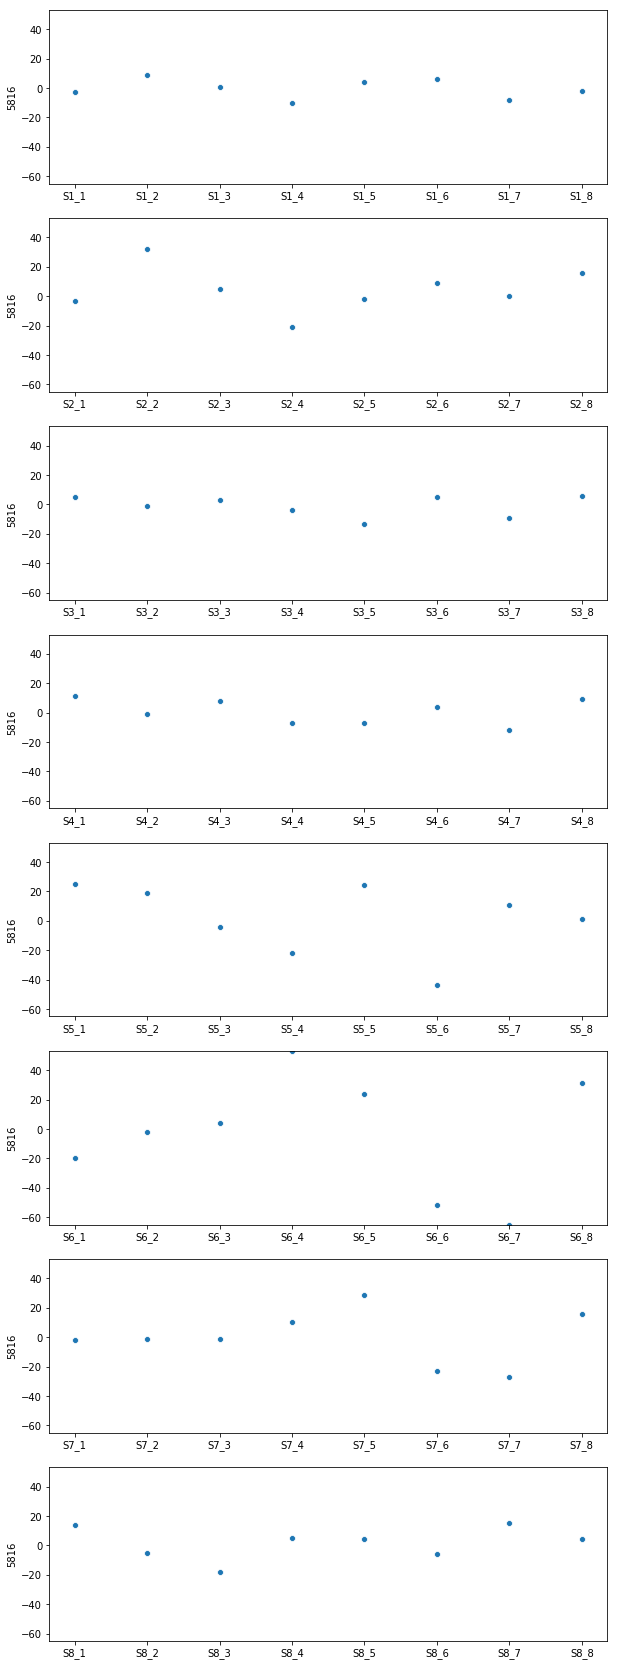

In [176]:
# label 0 > 0 - 2909
# label 1 > 2910 - 5812
# label 2 > 5813 - 8755
# label 3 > 8756 - 11678
plot_sensors_values(data, nr=5816)

# Muscle - nerve activity

In [190]:
def sum_of_absolute_values_per_sensor (data):
    
    S1 = data.loc[:,dict_columns_to_sensor['S1']]
    S2 = data.loc[:,dict_columns_to_sensor['S2']]
    S3 = data.loc[:,dict_columns_to_sensor['S3']]
    S4 = data.loc[:,dict_columns_to_sensor['S4']]
    S5 = data.loc[:,dict_columns_to_sensor['S5']]
    S6 = data.loc[:,dict_columns_to_sensor['S6']]
    S7 = data.loc[:,dict_columns_to_sensor['S7']]
    S8 = data.loc[:,dict_columns_to_sensor['S8']]
    
    
    
    muscle_nerv_activity = pd.DataFrame(data = {'S1': S1.abs().apply('sum', axis=1), 'S2':S2.abs().apply('sum', axis=1),
                                                'S3':S3.abs().apply('sum', axis=1),
                                                'S4':S4.abs().apply('sum', axis=1), 'S5':S5.abs().apply('sum', axis=1),
                                                'S6':S6.abs().apply('sum', axis=1), 'S7':S7.abs().apply('sum', axis=1),
                                                'S8':S8.abs().apply('sum', axis=1)})
    muscle_nerv_activity['label'] = data['label']
    
    return muscle_nerv_activity


In [198]:
mna = sum_of_absolute_values_per_sensor(data)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(mna.drop('label',axis=1))
scaled_mna = scaler.transform(mna.drop('label',axis=1))
mna_scaled = pd.DataFrame(data = scaled_mna, columns = mna.columns[:-1])
mna_scaled['label'] = mna['label']
mna_scaled.head()

,S1,S2,S3,S4,S5,S6,S7,S8,label
0,1.835868,-0.555349,0.288408,1.434192,-0.030452,-0.473500,3.754578,3.193190,0
1,2.133513,-0.176467,0.417172,0.575623,-0.030452,-0.322148,3.412111,1.497124,0
2,0.225080,-0.062802,0.739083,0.692701,0.055884,-0.019443,4.126824,4.415087,0
3,0.067503,-0.384852,0.674701,-0.087817,0.487567,-0.005684,3.024975,1.314751,0
4,2.256073,-0.536404,-0.226650,0.575623,0.012716,-0.432222,3.330217,3.138478,0


In [247]:
X_train, X_test, y_train, y_test = train_test_split(mna_scaled.drop(columns='label'),mna_scaled['label'],
                                                    test_size=0.30)
kmeans = KMeans(n_clusters=300)

kmeans.fit(mna_scaled.drop(columns = 'label'))

nerve_activity = kmeans.labels_

data_with_nerve_activity = data.copy()
data_with_nerve_activity['nerves_activity'] = nerve_activity


In [248]:
data_with_nerve_activity2 = data_with_nerve_activity[['label', 'nerves_activity']]

             precision    recall  f1-score   support

          0       0.99      0.98      0.98       901
          1       0.89      0.92      0.91       863
          2       0.92      0.92      0.92       881
          3       0.88      0.86      0.87       859

avg / total       0.92      0.92      0.92      3504



In [184]:
S1 = data.loc[:,dict_columns_to_sensor['S1']]
S1.abs().apply('sum', axis=1)

0        202.0
1        219.0
2        110.0
3        101.0
4        226.0
5        182.0
6        149.0
7        177.0
8        244.0
9        183.0
10       121.0
11       208.0
12       140.0
13       117.0
14       178.0
15       192.0
16       285.0
17       216.0
18       222.0
19       192.0
20       135.0
21       217.0
22        68.0
23       184.0
24       159.0
25       184.0
26       150.0
27       131.0
28       104.0
29       202.0
         ...  
11648     31.0
11649     44.0
11650     35.0
11651     36.0
11652     38.0
11653     41.0
11654     44.0
11655     54.0
11656     32.0
11657     28.0
11658     15.0
11659     46.0
11660     27.0
11661     38.0
11662     26.0
11663     13.0
11664     94.0
11665     64.0
11666     34.0
11667     26.0
11668     41.0
11669     35.0
11670     85.0
11671     32.0
11672     52.0
11673     46.0
11674     68.0
11675     34.0
11676     27.0
11677     34.0
Length: 11678, dtype: float64

(-40, 40)

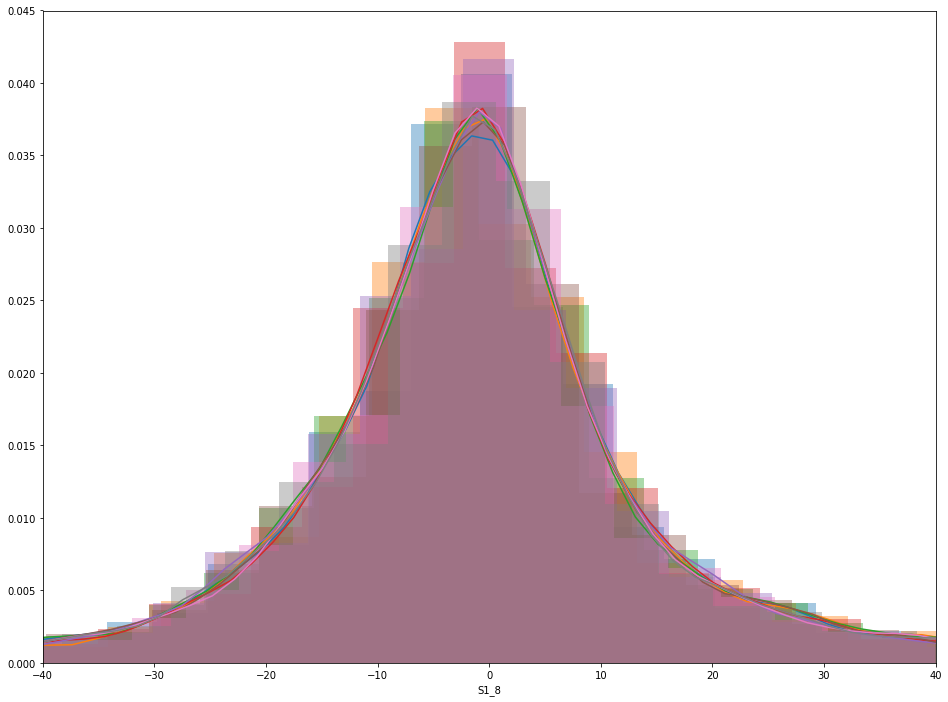

In [10]:
fig = plt.figure(figsize=(16,12))
for i in range (1,9):
    a = 'S1_' + str(i)
    fig = sns.distplot(S1[a])
fig.set_xlim([-40,40])


Maximal voluntary contraction
One basic function of EMG is to see how well a muscle can be activated. The most common way that can be determined is by performing a maximal voluntary contraction (MVC) of the muscle that is being tested.[13]

Muscle force, which is measured mechanically, typically correlates highly with measures of EMG activation of muscle. Most commonly this is assessed with surface electrodes, but it should be recognized that these typically only record from muscle fibers in close approximation to the surface.

Several analytical methods for determining muscle activation are commonly used depending on the application. The use of mean EMG activation or the peak contraction value is a debated topic. Most studies commonly use the maximal voluntary contraction as a means of analyzing peak force and force generated by target muscles. According to the article, Peak and average rectified EMG measures: Which method of data reduction should be used for assessing core training exercises?,[14] concluded that the “average rectified EMG data (ARV) is significantly less variable when measuring the muscle activity of the core musculature compared to the peak EMG variable.” Therefore, these researchers would suggest that “ARV EMG data should be recorded alongside the peak EMG measure when assessing core exercises.” Providing the reader with both sets of data would result in enhanced validity of the study and potentially eradicate the contradictions within the research.[15][16]

# Data Prep I
Thus:
Ist aproach - return a max value for each sensor and when it happens

In [11]:
data
sensors = [('S'+str(i)) for i in range(1,9)]


list_of_sensor_groups = []
for j in sensors:
    sensor_group = []
    for i in columns:
        if str(j) in i:
            sensor_group.append(i)
    list_of_sensor_groups.append(sensor_group)        

In [12]:
data[list_of_sensor_groups[0]].iloc[0,:].max()

61.0

In [13]:
matchingVals = [x for x in data[list_of_sensor_groups[0]].iloc[0,:] if x == data[list_of_sensor_groups[0]].iloc[0,:].max()]

In [14]:
matchingVals

[61.0]

## Raw Start

In [15]:
X = data.drop(columns='label')
y=data['label']

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
SSS = StratifiedShuffleSplit()

for train_index, test_index in SSS.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [17]:
#X_train.join(y_train)    #### Zrób żey działało

In [18]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_train_scaled = ssc.fit_transform(X_train)
X_test_scaled = ssc.transform(X_test)


## Data Selcetor

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Pipelines

In [20]:
from sklearn.pipeline import Pipeline

Ist_pipeline = Pipeline([

('std_scaler', StandardScaler()),
])

X_Ist_pipeline = Ist_pipeline.fit_transform(X)

## RandomForesClassifier 

In [227]:
class performance_meassure_pack ():
    #model, Xtrain, Xtest, ytrain, ytest
    def __init__(self, model, Xtrain, Xtest, ytrain, ytest):
        self.model = model
        self.Xtrain = Xtrain
        self.Xtest=Xtest
        self.ytrain = ytrain
        self.ytest = ytest
        self.model_results_one_label_in_multi_clf = 0
        self.conf_matrix = 0
  #self.model, self.Xtrain, self.Xtest, self.ytrain, self.ytest  
    
    def performance_meassure_for_one_label_in_multiclass_clf(self):
        
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import precision_score, recall_score, f1_score

        list_of_conf_matrix = []
        list_of_prec_scores = []
        list_of_recall_scores = []
        list_of_f1scores = []
        
        
        for i in list(self.ytrain.unique()):
            y_train_one_label = (self.ytrain == i)
            y_test_one_label = (self.ytest == i)
            #self.model = SGDClassifier()
            self.model.fit(self.Xtrain, y_train_one_label)
            y_pred_mc = self.model.predict(self.Xtest)

            prec_score = precision_score(y_test_one_label, y_pred_mc)

            rec_score = recall_score(y_test_one_label, y_pred_mc)

            conf_matrix = confusion_matrix(y_test_one_label, y_pred_mc)

            f1score = f1_score(y_test_one_label, y_pred_mc)

            list_of_conf_matrix.append(conf_matrix)
            list_of_prec_scores.append(prec_score)
            list_of_recall_scores.append(rec_score)
            list_of_f1scores.append(f1score)

        d = {'recal':list_of_recall_scores, 'prec':list_of_prec_scores, 'f1score' : list_of_f1scores}    
        model_results = pd.DataFrame(data =d,index = list(y_train.unique()) )
        #self.model_results = model_results
        self.model_results_one_label_in_multi_clf = model_results
        
    def MultiClass_ErrorAnalysis_HeatMap(self):
        from sklearn.metrics import confusion_matrix
        
        self.model.fit(self.Xtrain, self.ytrain)
        y_pred = self.model.predict(self.Xtest)

        conf_matrix = confusion_matrix(self.ytest, y_pred)

        conf_matrix2= conf_matrix.copy()
        conf_matrix2[np.diag_indices_from(conf_matrix2)] = 0
        self.conf_matrix = conf_matrix
        

        fig = plt.figure(figsize=(12,10))
        fig = sns.heatmap(conf_matrix2)
        fig.set_xticklabels(list(self.model.classes_))  
        fig.set_yticklabels(list(self.model.classes_))  
        
        
        

In [22]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()


In [23]:
y_train2 = (y_train == 0)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RFC, X_train_scaled, y_train2,
scoring="precision", cv=4)

In [24]:
pmp = performance_meassure_pack(RFC, X_train_scaled, X_test_scaled, y_train, y_test)
pmp.performance_meassure_for_one_label_in_multiclass_clf()
results_df = pmp.model_results_one_label_in_multi_clf

In [25]:
results_df

,recal,prec,f1score
2,0.796610,0.943775,0.863971
3,0.575342,0.933333,0.711864
0,0.945017,0.948276,0.946644
1,0.831034,0.956349,0.889299


# Error Analysis I 

[Text(0,0.5,'0'), Text(0,1.5,'1'), Text(0,2.5,'2'), Text(0,3.5,'3')]

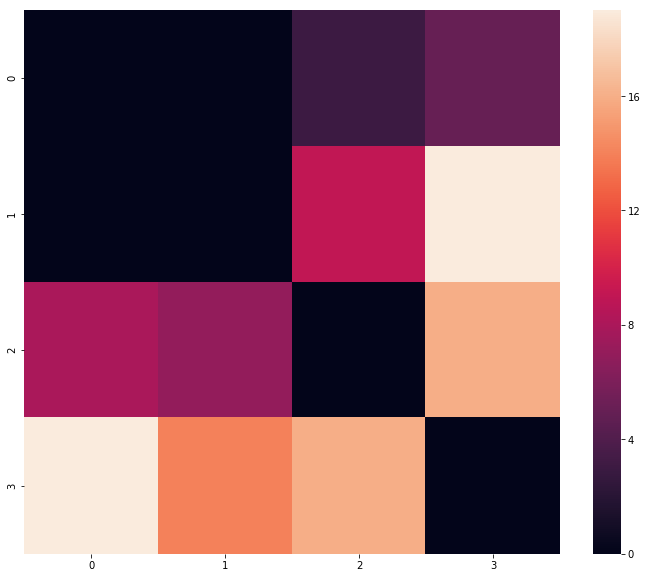

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


RFC.fit(X_train_scaled, y_train)
y_pred = RFC.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix2= conf_matrix.copy()
conf_matrix2[np.diag_indices_from(conf_matrix2)] = 0

fig = plt.figure(figsize=(12,10))
fig = sns.heatmap(conf_matrix2)
fig.set_xticklabels(list(RFC.classes_))  
fig.set_yticklabels(list(RFC.classes_))  

In [27]:
conf_matrix

array([[283,   0,   3,   5],
       [  0, 262,   9,  19],
       [  8,   7, 264,  16],
       [ 19,  14,  16, 243]], dtype=int64)

# Logistic Regresion

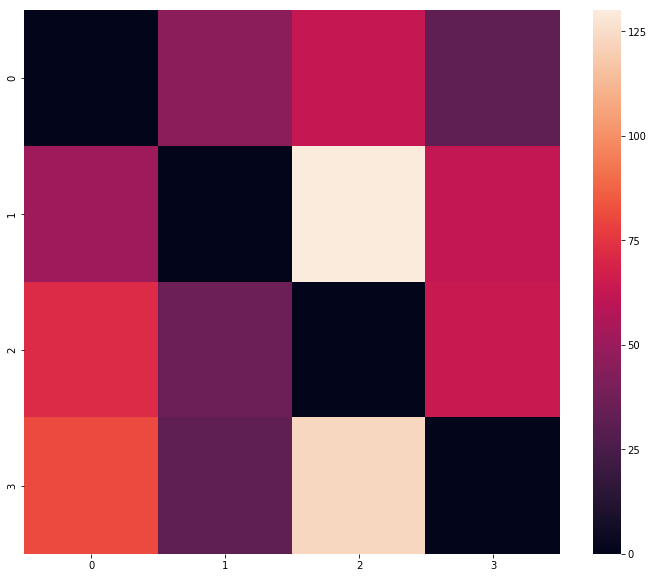

In [28]:
from sklearn.linear_model import LogisticRegressionCV
LogRegCV = LogisticRegressionCV()
pmp_LogRegCV = performance_meassure_pack(LogRegCV, X_train_scaled, X_test_scaled, y_train, y_test )
pmp_LogRegCV.MultiClass_ErrorAnalysis_HeatMap()

In [29]:
pmp_LogRegCV.conf_matrix

array([[151,  45,  63,  32],
       [ 51,  47, 130,  62],
       [ 72,  36, 123,  64],
       [ 81,  32, 123,  56]], dtype=int64)

## Supported Vector Classifier

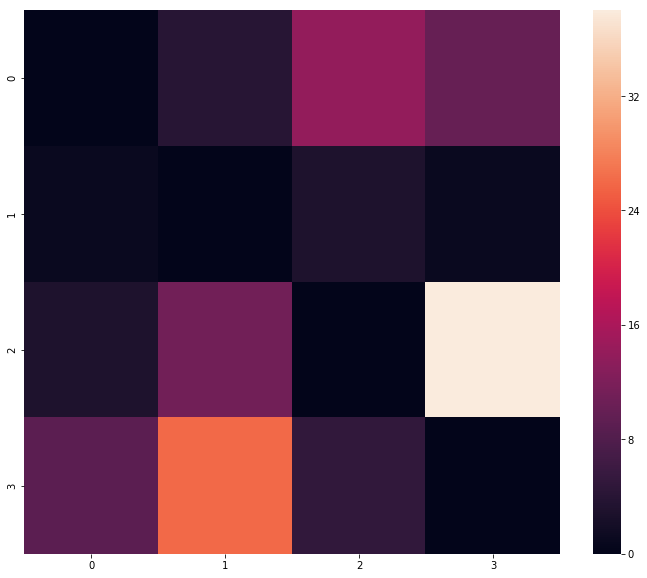

In [30]:
from sklearn.svm import SVC
SVC_clf = SVC()
pmp_SVC = performance_meassure_pack(SVC_clf, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_SVC.MultiClass_ErrorAnalysis_HeatMap()

In [31]:
pmp_SVC.conf_matrix

array([[263,   4,  14,  10],
       [  1, 285,   3,   1],
       [  3,  11, 243,  38],
       [  9,  26,   5, 252]], dtype=int64)

# Voting Classifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


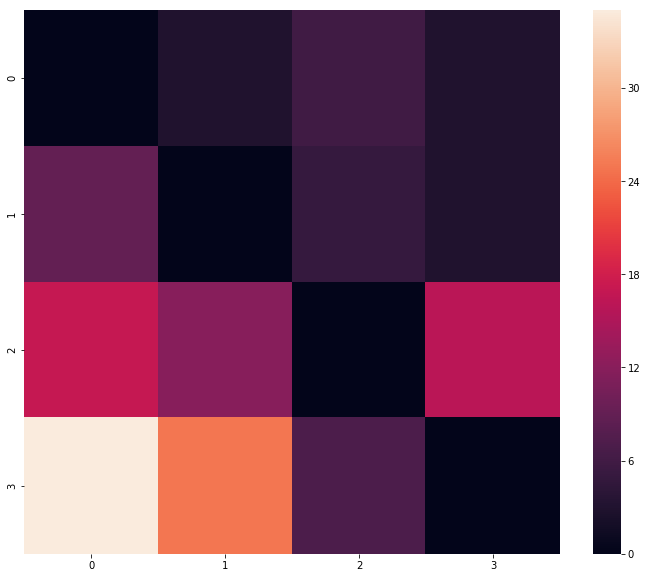

In [32]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('lr', LogRegCV), ('rf', RFC), ('svc', SVC_clf)],voting='hard')

pmp_voting = performance_meassure_pack(voting_clf, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_voting.MultiClass_ErrorAnalysis_HeatMap()

In [33]:
pmp_voting.conf_matrix

array([[279,   3,   6,   3],
       [  9, 273,   5,   3],
       [ 17,  12, 250,  16],
       [ 35,  25,   7, 225]], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


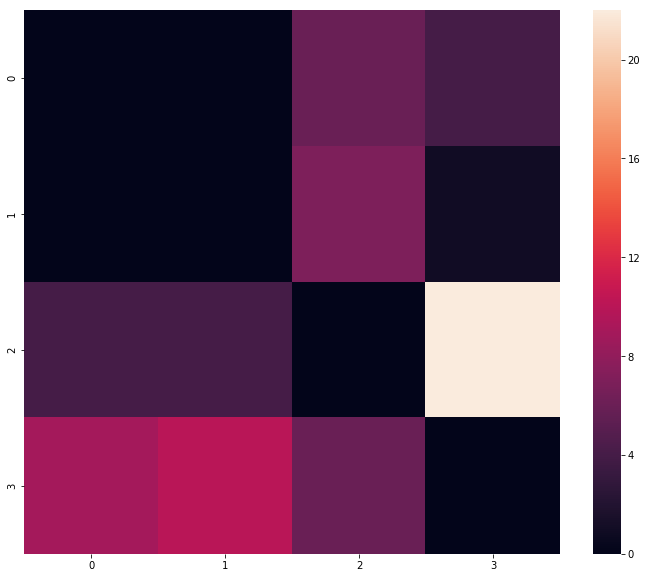

In [34]:
SVC_clf2 = SVC(probability=True)
#voting_clf2 = VotingClassifier(estimators=[('lr', LogRegCV), ('rf', RFC), ('svc', SVC_clf2)],voting='soft')
voting_clf2 = VotingClassifier(estimators=[('rf', RFC), ('svc', SVC_clf2)],voting='soft')
pmp_voting2 = performance_meassure_pack(voting_clf2, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_voting2.MultiClass_ErrorAnalysis_HeatMap()

In [35]:
pmp_voting2.conf_matrix

array([[281,   0,   6,   4],
       [  0, 282,   7,   1],
       [  4,   4, 265,  22],
       [  9,  10,   6, 267]], dtype=int64)

In [36]:
conf_matrix

array([[283,   0,   3,   5],
       [  0, 262,   9,  19],
       [  8,   7, 264,  16],
       [ 19,  14,  16, 243]], dtype=int64)

## RFC - bagging/grid search

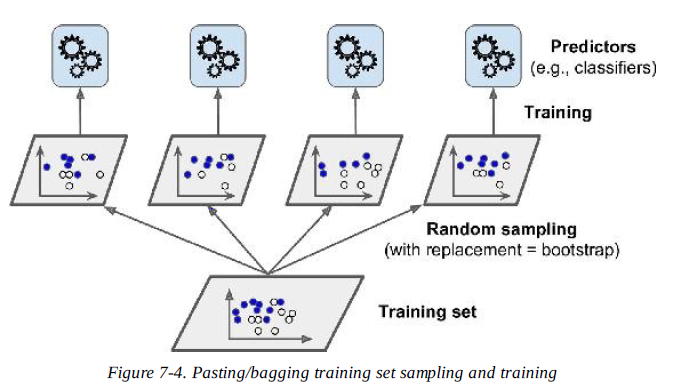

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    #{'bootstrap': [True], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    {'bootstrap': [False], 'n_estimators': [50, 100, 150], 'max_features': ['auto']},
    ]
RFC_GC = RandomForestClassifier()
grid_search = GridSearchCV(RFC_GC, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'bootstrap': [False], 'n_estimators': [50, 100, 150], 'max_features': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 100}

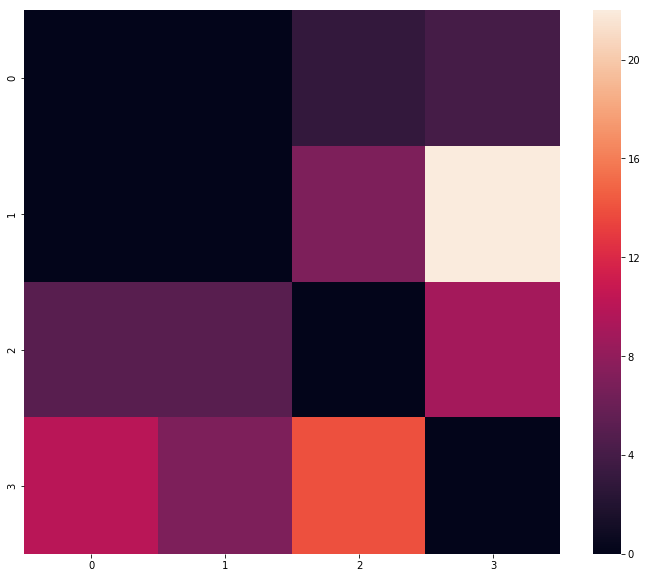

In [39]:
RFC_GC = RandomForestClassifier(bootstrap=False, max_features='auto', n_estimators=150, n_jobs=-1)
pmp_RFC_GC = performance_meassure_pack(RFC_GC, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_RFC_GC.MultiClass_ErrorAnalysis_HeatMap()

In [40]:
pmp_RFC_GC.conf_matrix

array([[284,   0,   3,   4],
       [  0, 261,   7,  22],
       [  5,   5, 276,   9],
       [ 10,   7,  14, 261]], dtype=int64)

In [41]:
conf_matrix

array([[283,   0,   3,   5],
       [  0, 262,   9,  19],
       [  8,   7, 264,  16],
       [ 19,  14,  16, 243]], dtype=int64)

# Voting Classifier 2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


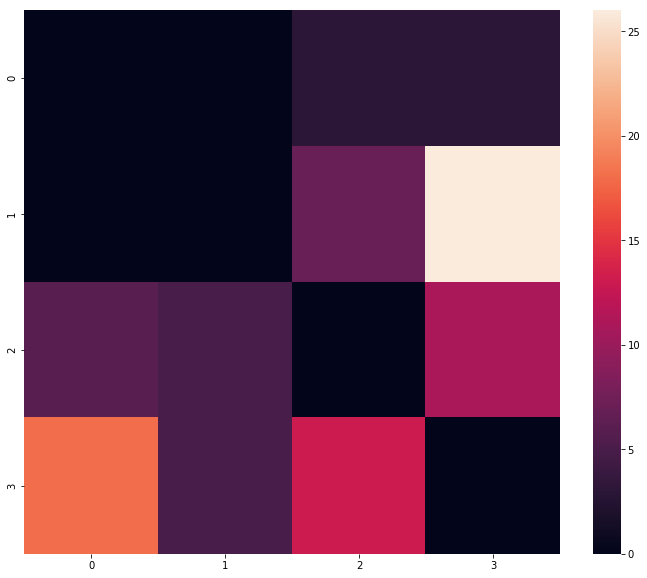

In [42]:
voting_clf2 = VotingClassifier(estimators=[('rf', RFC), ('rfc_GS', RFC_GC)],voting='soft')

pmp_voting2 = performance_meassure_pack(voting_clf2, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_voting2.MultiClass_ErrorAnalysis_HeatMap()

In [43]:
pmp_voting2.conf_matrix

array([[285,   0,   3,   3],
       [  0, 257,   7,  26],
       [  6,   5, 273,  11],
       [ 18,   5,  13, 256]], dtype=int64)

In [44]:
pmp_voting.conf_matrix

array([[279,   3,   6,   3],
       [  9, 273,   5,   3],
       [ 17,  12, 250,  16],
       [ 35,  25,   7, 225]], dtype=int64)

In [45]:
pmp_RFC_GC.conf_matrix

array([[284,   0,   3,   4],
       [  0, 261,   7,  22],
       [  5,   5, 276,   9],
       [ 10,   7,  14, 261]], dtype=int64)

## Grid Search 2

In [46]:
param_grid2 = [
    #{'bootstrap': [True], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    {'bootstrap': [False], 'n_estimators': [150, 250], 'max_features': ['auto']},
    ]
RFC_GC2 = RandomForestClassifier()
grid_search2 = GridSearchCV(RFC_GC2, param_grid2, cv=5, scoring='accuracy')
grid_search2.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'bootstrap': [False], 'n_estimators': [150, 250], 'max_features': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
grid_search2.best_params_

{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 250}

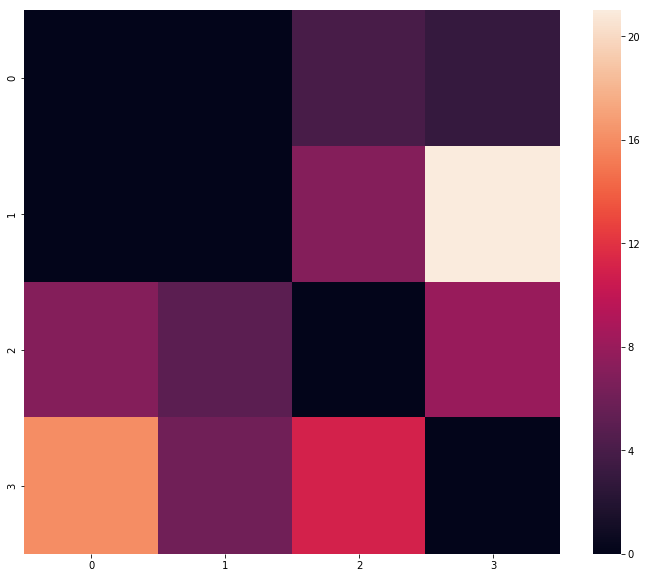

In [48]:
RFC_GC2 = RandomForestClassifier(bootstrap=False, max_features='auto', n_estimators=250, n_jobs=-1)
pmp_RFC_GC2 = performance_meassure_pack(RFC_GC2, X_train_scaled, X_test_scaled, y_train, y_test)
pmp_RFC_GC2.MultiClass_ErrorAnalysis_HeatMap()

In [49]:
pmp_RFC_GC2.conf_matrix

array([[284,   0,   4,   3],
       [  0, 262,   7,  21],
       [  7,   5, 275,   8],
       [ 16,   6,  11, 259]], dtype=int64)

In [50]:
pmp_RFC_GC.conf_matrix

array([[284,   0,   3,   4],
       [  0, 261,   7,  22],
       [  5,   5, 276,   9],
       [ 10,   7,  14, 261]], dtype=int64)

# Feature adder

In [51]:
data2 = data.copy()



In [52]:

columns = [ t for t in data.columns if t.startswith('S1') ]
data_c = data2[columns]
data_c
sensor_peak_value = data_c.max(axis=1)
#for i in sensor_peak_value.index:
peak_position_list = []
sensor_peak_value = data_c.max(axis=1)
for i in sensor_peak_value.index:
    p = data_c.iloc[i,:][data_c.iloc[i, :] == sensor_peak_value[i]].first_valid_index()
    peak_position = int(p[3])
    peak_position_list.append(peak_position) 

In [53]:
def peak_value_and_position(data):
    
    peaks = data.max(axis=1)
    
    for i in range(1,9):
        columns = [ t for t in data.columns if t.startswith('S'+str(i)) ]
        data_c = data[columns]
        sensor_peak_value = data_c.max(axis=1)
        peak_position_list = []
        
        for j in sensor_peak_value.index:
            p = data_c.iloc[j,:][data_c.iloc[j, :] == sensor_peak_value[j]].first_valid_index()
            peak_position = int(p[3])
            peak_position_list.append(peak_position)
            
        data['peak_position sensor S' + str(i)] = peak_position_list
        data['peak_value sensor S' + str(i)] = sensor_peak_value
        
    return data

In [54]:
data3 = peak_value_and_position(data2)

In [55]:
data4 = data3.iloc[:, 64:]


In [56]:
from sklearn.model_selection import train_test_split

X_train4, X_test4, y_train4, y_test4 = train_test_split(data4.iloc[:, 1:], data4.iloc[:,0])
RFC_data4 = RandomForestClassifier()
pmp_RFC_data4 = performance_meassure_pack(RFC_data4, X_train4, X_test4, y_train4, y_test4 )


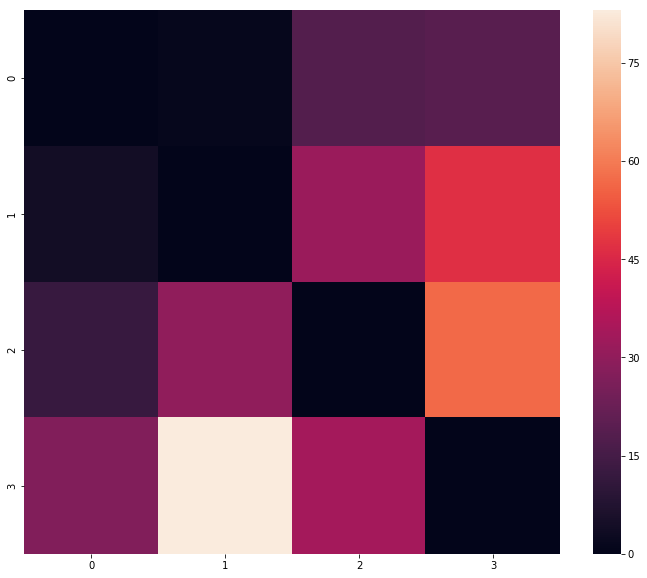

In [57]:
pmp_RFC_data4.MultiClass_ErrorAnalysis_HeatMap()

In [58]:
pmp_RFC_data4.conf_matrix

array([[678,   1,  18,  19],
       [  4, 639,  32,  47],
       [ 12,  30, 633,  57],
       [ 27,  83,  34, 606]], dtype=int64)

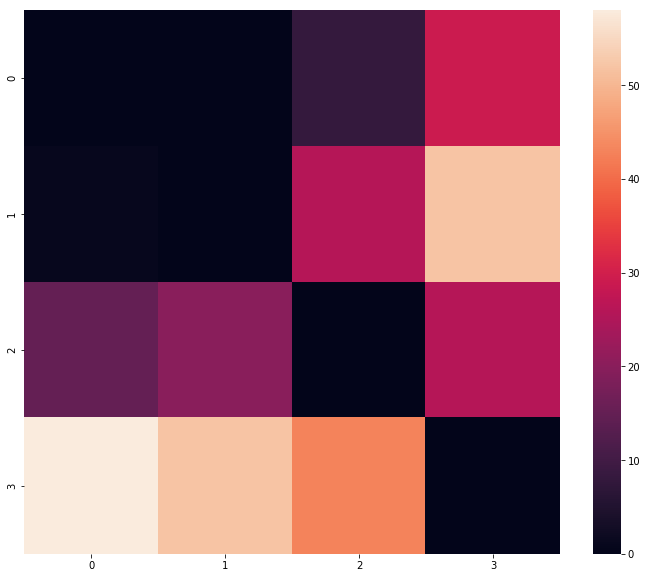

In [59]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(data.drop(columns = 'label'), data['label'])
RFC = RandomForestClassifier()
pmp_RFC = performance_meassure_pack(RFC, X_train4, X_test4, y_train4, y_test4 )
pmp_RFC.MultiClass_ErrorAnalysis_HeatMap()

In [60]:
pmp_RFC.conf_matrix

array([[729,   0,   8,  29],
       [  1, 615,  26,  52],
       [ 15,  20, 659,  26],
       [ 58,  52,  43, 587]], dtype=int64)

In [61]:
data4.head()

,label,peak_position sensor S1,peak_value sensor S1,peak_position sensor S2,peak_value sensor S2,peak_position sensor S3,peak_value sensor S3,peak_position sensor S4,peak_value sensor S4,peak_position sensor S5,peak_value sensor S5,peak_position sensor S6,peak_value sensor S6,peak_position sensor S7,peak_value sensor S7,peak_position sensor S8,peak_value sensor S8
0,0,8,61.0,3,6.0,8,8.0,2,13.0,3,27.0,3,20.0,3,91.0,3,71.0
1,0,8,47.0,3,10.0,5,11.0,5,11.0,3,23.0,3,63.0,8,111.0,3,49.0
2,0,6,27.0,6,7.0,2,4.0,2,16.0,2,24.0,6,23.0,6,127.0,6,69.0
3,0,7,28.0,6,8.0,6,8.0,8,11.0,8,33.0,8,39.0,8,119.0,8,43.0
4,0,4,75.0,7,5.0,7,5.0,2,13.0,4,14.0,5,15.0,4,87.0,4,56.0


# Feature adder - slope

In [252]:
def peak_value_and_position_and_slope(data, slope_v = True):
    
    peaks = data.max(axis=1)
    
    for i in range(1,9): #### nie działa przez to na wycinkach!!!!! ####
        columns = [ t for t in data.columns if t.startswith('S'+str(i)) ]
        data_c = data[columns]
        sensor_peak_value = data_c.max(axis=1)
        peak_position_list = []
        slope_list=[]
        
        for j in sensor_peak_value.index:
            p = data_c.iloc[j,:][data_c.iloc[j, :] == sensor_peak_value[j]].first_valid_index()
            peak_position = int(p[3])
            
            if slope_v == True:
                
                left = peak_position - 1
                
                if left > 0:
                    ind = ('S'+str(i)+'_'+str(left))
                    slope = data_c.iloc[j,peak_position-1] - data_c.loc[j,ind]
                    slope_list.append(slope)
                else:
                    slope = 0
                    slope_list.append(slope)
                    
            #slope_list.append(slope)
            peak_position_list.append(peak_position)
            
        data['peak left slope value sensor S' + str(i)] = slope_list    
        data['peak_position sensor S' + str(i)] = peak_position_list
        data['peak_value sensor S' + str(i)] = sensor_peak_value
        
    return data

columns = [ t for t in data.columns if t.startswith('S'+str(i)) ]
data_c = data[columns]
sensor_peak_value = data_c.max(axis=1)
sensor_peak_value

p = data_c.iloc[0,:][data_c.iloc[0, :] == sensor_peak_value[0]].first_valid_index()
peak_position = int(p[3])
peak_position
left = peak_position - 1
left
ind = ('S'+str(8)+'_'+str(left))
data_c.loc[0,ind]
data_c.iloc[0,peak_position-1]

In [195]:
data6 = peak_value_and_position_and_slope(data2.drop(columns='label'))


def slope (row):
    for i in range(1,9):
        columns = [ t for t in data.columns if t.startswith('S'+str(i)) ]
        
    return columns

data_test['test'] = data_test.apply(slope, axis=1)

columns = [ t for t in data6.columns if t.startswith('S'+str(2)) ]
data6[columns].head()

columns = [ t for t in data6.columns if t.startswith('slop') ]
data6[columns]

columns = [ t for t in data.columns if t.startswith('S'+str(i)) ]
data_c = data2[columns]
sensor_peak_value = data_c.max(axis=1)


In [64]:

y = data2['label']
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6,y)
RFC_data6 = RandomForestClassifier()
pmp_RFC_data6 = performance_meassure_pack(RFC_data6, X_train6, X_test6, y_train6, y_test6)

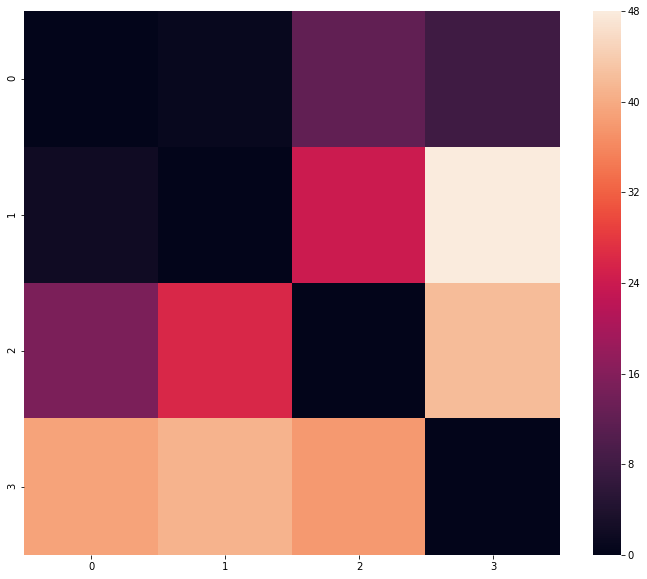

In [65]:
pmp_RFC_data6.MultiClass_ErrorAnalysis_HeatMap()

In [66]:
pmp_RFC_data6.conf_matrix

array([[729,   1,  12,   8],
       [  2, 652,  24,  48],
       [ 15,  26, 664,  42],
       [ 39,  41,  38, 579]], dtype=int64)

In [67]:
conf_matrix

array([[283,   0,   3,   5],
       [  0, 262,   9,  19],
       [  8,   7, 264,  16],
       [ 19,  14,  16, 243]], dtype=int64)

## Featur weights

In [86]:
## It does nothing

sensor_col_names = [j + str(k) for k in list(range(1,9)) for j in['S' + str(i) + '_' for i in range(1,9)]]
sensor_col_names

def col_names_creator1(x):
    return x.startswith('peak_position')

def col_names_creator2(x):
    return x.startswith('peak left')

def col_names_creator3(x):
    return x.startswith('peak_value')

peak_position_col_names = list(filter(col_names_creator1, data6.columns))
peak_left_slope_col_names = list(filter(col_names_creator2, data6.columns))
peak_value_col_names = list(filter(col_names_creator3, data6.columns))


def feature_weights(x, multiply_val):
    return x*multiply_val

In [169]:
list_of_conf_matrix_data7 = []
list_of_weights = []

for i in [0.01, 1]:
    for j in [1, 10]:
        for z in [10, 100]:
            for g in [1, 100, 1000]:
                data7 = data6.copy()

                data7[sensor_col_names] = data7[sensor_col_names].apply(lambda x: feature_weights(x, i), axis = 1)
                data7[peak_position_col_names] = data7[peak_position_col_names].apply(lambda x: feature_weights(x, i), axis = 1)
                data7[peak_left_slope_col_names] = data7[peak_left_slope_col_names].apply(lambda x: feature_weights(x, z), axis = 1)
                data7[peak_value_col_names] = data7[peak_value_col_names].apply(lambda x: feature_weights(x, g), axis = 1)
                
                RFC_data7 = RandomForestClassifier(random_state=101, n_jobs=-1)
                data7 = ssc.fit_transform(data7) #scaler
                X_train7, X_test7, y_train7, y_test7 = train_test_split(data7, y, random_state = 42, train_size = 0.8)
                
                RFC_data7.fit(X_train7, y_train7)
                y_pred7 = RFC_data7.predict(X_test7)
                C_matrix = confusion_matrix(y_test7, y_pred7)
                
                list_of_conf_matrix_data7.append(C_matrix)
                list_of_weights.append(list((i, j, z, g)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are spe

In [175]:
#my_scorer
a = list_of_conf_matrix_data7[2]
a.diagonal()[3]/a[3].sum()

0.8477508650519031

In [162]:
list_of_weights[20]

[1, 10, 10, 1000]

In [ ]:
## GridSearch, data6

In [186]:
a = list(data6.columns.unique())
len(a)

88

In [197]:
data7=data6.drop(columns = sensor_col_names)
len(data7.columns)

24

In [213]:
param_grid2 = [
    #{'bootstrap': [True], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 30], 'max_features': [16, 24]},
    #{'bootstrap': [False], 'n_estimators': [30, 60], 'max_features': [18, 24]}
    #{'bootstrap': [False], 'n_estimators': [60, 100], 'max_features': [20, 24]}
    #{'bootstrap': [False], 'n_estimators': [180, 200, 220], 'max_features': [19,20,21]}
    {'bootstrap': [False], 'n_estimators': [180, 200, 220], 'max_features': [19,20,21]}
    ]

data7 = ssc.fit_transform(data7)
X_train6, X_test6, y_train6, y_test6 = train_test_split(data7, y)

RFC_GC2 = RandomForestClassifier(random_state = 42)
grid_search2 = GridSearchCV(RFC_GC2, param_grid2, cv=4, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X_train6, y_train6)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'bootstrap': [False], 'n_estimators': [180, 200, 220], 'max_features': [19, 20, 21]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [214]:
grid_search2.best_params_

{'bootstrap': False, 'max_features': 19, 'n_estimators': 220}

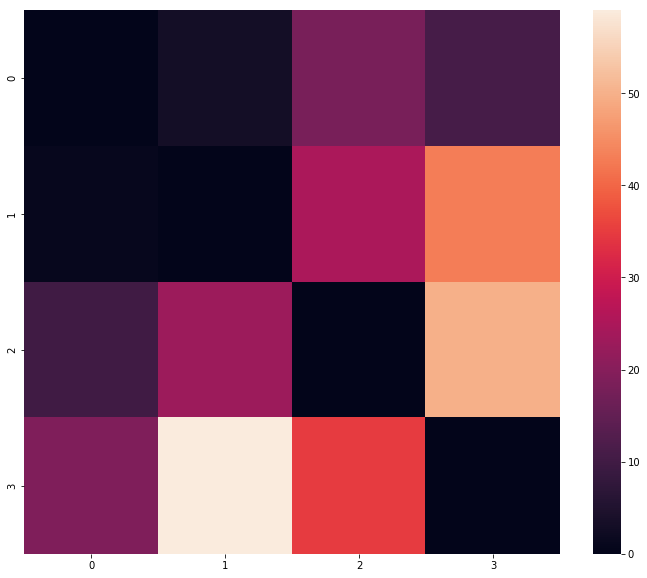

In [215]:
RFC_GC3 = RandomForestClassifier(max_features=19, n_estimators= 220, bootstrap= False, random_state = 42)
#RFC_GC3.fit(X_train6, y_)

pmp_RFC_GC3 = performance_meassure_pack(RFC_GC3, X_train6, X_test6, y_train6, y_test6 )
pmp_RFC_GC3.MultiClass_ErrorAnalysis_HeatMap()

In [216]:
pmp_RFC_GC3.conf_matrix

array([[714,   3,  18,  11],
       [  1, 681,  25,  43],
       [ 10,  23, 643,  50],
       [ 19,  59,  35, 585]], dtype=int64)

In [217]:
pmp_RFC_data6.conf_matrix

array([[729,   1,  12,   8],
       [  2, 652,  24,  48],
       [ 15,  26, 664,  42],
       [ 39,  41,  38, 579]], dtype=int64)

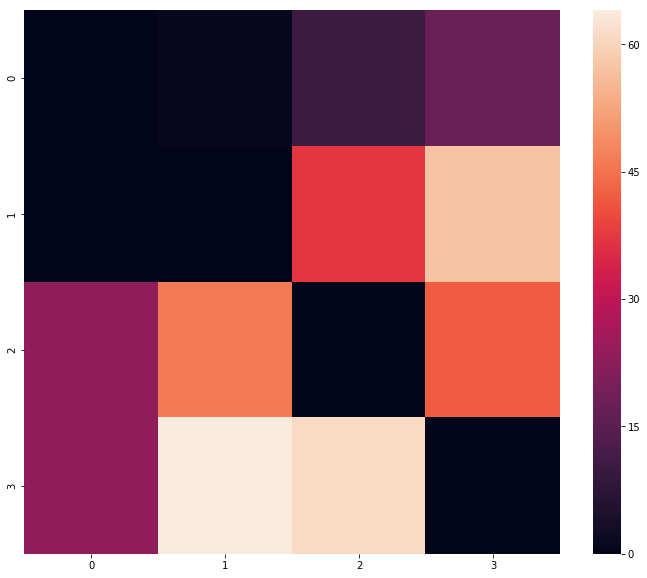

In [225]:
RFC_GCx = RandomForestClassifier(max_features=24, n_estimators= 300, bootstrap= False, random_state = 42)
#RFC_GC3.fit(X_train6, y_)

pmp_RFC_GCx = performance_meassure_pack(RFC_GC3, X_train6, X_test6, y_train6, y_test6 )
pmp_RFC_GCx.MultiClass_ErrorAnalysis_HeatMap()

In [226]:
pmp_RFC_GCx.conf_matrix

array([[656,   1,  10,  17],
       [  0, 646,  37,  57],
       [ 23,  46, 641,  42],
       [ 23,  64,  61, 596]], dtype=int64)

## scoring = precission

In [229]:
param_grid2 = [
    #{'bootstrap': [True], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 30], 'max_features': [16, 24]},
    #{'bootstrap': [False], 'n_estimators': [30, 60], 'max_features': [18, 24]}
    #{'bootstrap': [False], 'n_estimators': [60, 100], 'max_features': [20, 24]}
    #{'bootstrap': [False], 'n_estimators': [180, 200, 220], 'max_features': [19,20,21]}
    {'bootstrap': [False], 'n_estimators': [200, 250], 'max_features': [16, 24]}
    ]

data7 = ssc.fit_transform(data7)
X_train6, X_test6, y_train6, y_test6 = train_test_split(data7, y)

RFC_GC2 = RandomForestClassifier(random_state = 42)
grid_search2 = GridSearchCV(RFC_GC2, param_grid2, cv=4, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X_train6, y_train6)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'bootstrap': [False], 'n_estimators': [200, 250], 'max_features': [16, 24]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [230]:
grid_search2.best_params_

{'bootstrap': False, 'max_features': 16, 'n_estimators': 250}

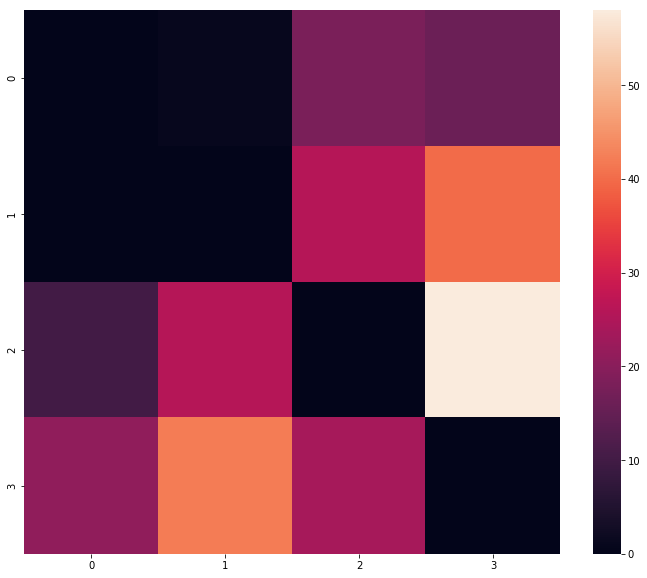

In [231]:
RFC_GC3 = RandomForestClassifier(max_features=16, n_estimators= 250, bootstrap= False, random_state = 42)
#RFC_GC3.fit(X_train6, y_)

pmp_RFC_GC3 = performance_meassure_pack(RFC_GC3, X_train6, X_test6, y_train6, y_test6 )
pmp_RFC_GC3.MultiClass_ErrorAnalysis_HeatMap()

In [232]:
pmp_RFC_GC3.conf_matrix

array([[712,   1,  18,  16],
       [  0, 641,  26,  40],
       [ 10,  26, 673,  58],
       [ 21,  42,  24, 612]], dtype=int64)

In [227]:
pmp_RFC_GC2.conf_matrix

array([[284,   0,   4,   3],
       [  0, 262,   7,  21],
       [  7,   5, 275,   8],
       [ 16,   6,  11, 259]], dtype=int64)

In [233]:
a = 641/(646+26+42)
b = 262/(262+11)
print(a,b)

0.8977591036414566 0.9597069597069597


# nerves activity

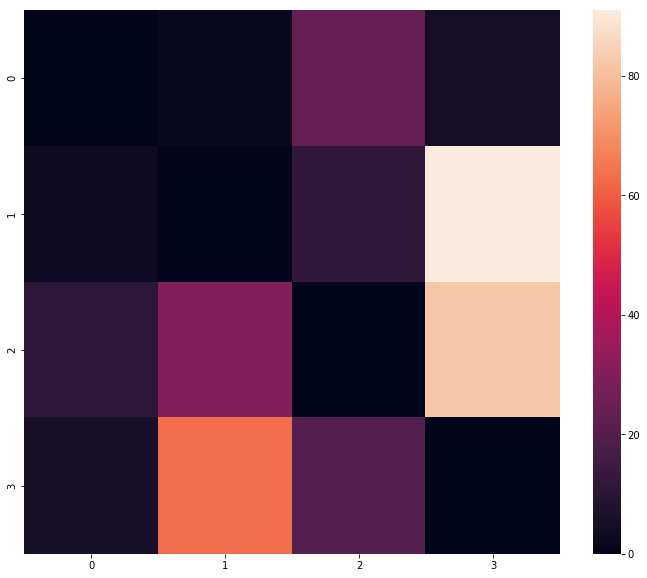

In [249]:
X_train_nerves_activity, X_test_nerves_activity, y_train_nerves_activity, y_test_nerves_activity = train_test_split(data_with_nerve_activity2['nerves_activity'], data_with_nerve_activity2['label'], test_size=0.33, random_state=42)
X_train_nerves_activity=X_train_nerves_activity.values.reshape(-1, 1)
X_test_nerves_activity=X_test_nerves_activity.values.reshape(-1, 1)



RFC_nerves_activity = RandomForestClassifier(random_state = 42)


pmp_RFC_nerves_activity = performance_meassure_pack(RFC_nerves_activity,
                                                    X_train_nerves_activity, X_test_nerves_activity,
                                                    y_train_nerves_activity, y_test_nerves_activity )
pmp_RFC_nerves_activity.MultiClass_ErrorAnalysis_HeatMap()

In [250]:
pmp_RFC_nerves_activity.conf_matrix

array([[932,   2,  24,   5],
       [  3, 885,  12,  91],
       [ 11,  30, 824,  82],
       [  6,  63,  20, 864]], dtype=int64)

# Nerves activity + slope and max values

In [260]:
data_nerves_activity_and_peak_values = peak_value_and_position_and_slope(data)

In [265]:
data_nerves_activity_and_peak_values= data_nerves_activity_and_peak_values[['peak left slope value sensor S1',
       'peak_position sensor S1', 'peak_value sensor S1',
       'peak left slope value sensor S2', 'peak_position sensor S2',
       'peak_value sensor S2', 'peak left slope value sensor S3',
       'peak_position sensor S3', 'peak_value sensor S3',
       'peak left slope value sensor S4', 'peak_position sensor S4',
       'peak_value sensor S4', 'peak left slope value sensor S5',
       'peak_position sensor S5', 'peak_value sensor S5',
       'peak left slope value sensor S6', 'peak_position sensor S6',
       'peak_value sensor S6', 'peak left slope value sensor S7',
       'peak_position sensor S7', 'peak_value sensor S7',
       'peak left slope value sensor S8', 'peak_position sensor S8',
       'peak_value sensor S8']]
data_nerves_activity_and_peak_values['nerve_activity'] = nerve_activity
data_nerves_activity_and_peak_values['label'] = data['label']

In [267]:
data_nerves_activity_and_peak_values.head()

,peak left slope value sensor S1,peak_position sensor S1,peak_value sensor S1,peak left slope value sensor S2,peak_position sensor S2,peak_value sensor S2,peak left slope value sensor S3,peak_position sensor S3,peak_value sensor S3,peak left slope value sensor S4,...,peak_position sensor S6,peak_value sensor S6,peak left slope value sensor S7,peak_position sensor S7,peak_value sensor S7,peak left slope value sensor S8,peak_position sensor S8,peak_value sensor S8,nerve_activity,label
0,88.0,8,61.0,4.0,3,6.0,7.0,8,8.0,5.0,...,3,20.0,210.0,3,91.0,116.0,3,71.0,227,0
1,87.0,8,47.0,14.0,3,10.0,18.0,5,11.0,14.0,...,3,63.0,216.0,8,111.0,101.0,3,49.0,206,0
2,48.0,6,27.0,14.0,6,7.0,12.0,2,4.0,24.0,...,6,23.0,203.0,6,127.0,113.0,6,69.0,193,0
3,50.0,7,28.0,13.0,6,8.0,16.0,6,8.0,16.0,...,8,39.0,173.0,8,119.0,81.0,8,43.0,199,0
4,159.0,4,75.0,4.0,7,5.0,2.0,7,5.0,15.0,...,5,15.0,215.0,4,87.0,111.0,4,56.0,227,0


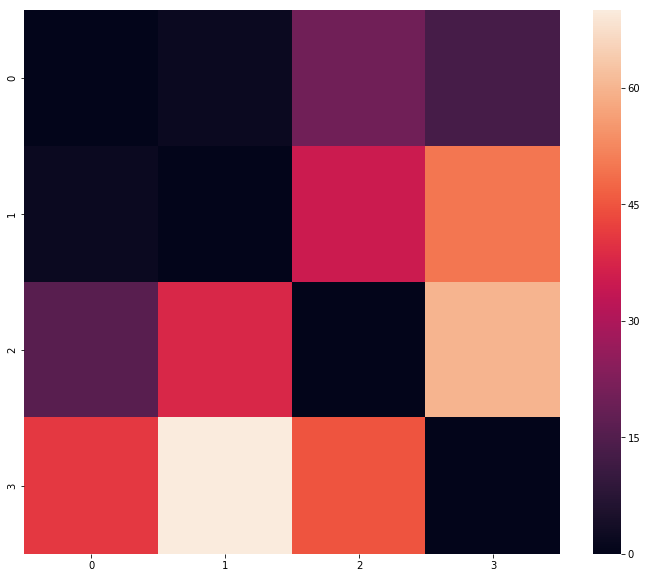

In [269]:
X_train_nerves_activity2, X_test_nerves_activity2, y_train_nerves_activity2, y_test_nerves_activity2 = train_test_split(data_nerves_activity_and_peak_values.drop(columns = 'label'), data_nerves_activity_and_peak_values['label'], test_size=0.33, random_state=42)
#X_train_nerves_activity=X_train_nerves_activity.values.reshape(-1, 1)
#X_test_nerves_activity=X_test_nerves_activity.values.reshape(-1, 1)



RFC_nerves_activity2 = RandomForestClassifier(random_state = 42)


pmp_RFC_nerves_activity2 = performance_meassure_pack(RFC_nerves_activity,
                                                    X_train_nerves_activity2, X_test_nerves_activity2,
                                                    y_train_nerves_activity2, y_test_nerves_activity2 )
pmp_RFC_nerves_activity2.MultiClass_ErrorAnalysis_HeatMap()

In [271]:
pmp_RFC_nerves_activity2.conf_matrix

array([[928,   2,  20,  13],
       [  2, 904,  35,  50],
       [ 16,  38, 833,  60],
       [ 41,  70,  45, 797]], dtype=int64)

In [294]:
param_grid2 = [
    #{'bootstrap': [True], 'n_estimators': [1, 10, 50], 'max_features': [13,25]},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': ['auto']},
    #{'bootstrap': [False], 'n_estimators': [1, 10, 50], 'max_features': [13,25]},
    #{'bootstrap': [False], 'n_estimators': [50, 100], 'max_features': [13,25]},
    #{'bootstrap': [False], 'n_estimators': [100, 300], 'max_features': [13,25]},
    #{'bootstrap': [False], 'n_estimators': [300], 'max_features': [11, 12, 13,14,15]},
    #{'bootstrap': [False], 'n_estimators': [300], 'max_features': [7,9,11]},
    #{'bootstrap': [False], 'n_estimators': [300], 'max_features': [4,5,6,7]},
    {'bootstrap': [False], 'n_estimators': [100, 300, 500], 'max_features': [4,5,6]},
    
    ]
RFC_GC2 = RandomForestClassifier()
grid_search2 = GridSearchCV(RFC_GC2, param_grid2, cv=5, scoring='accuracy')
grid_search2.fit(X_train_nerves_activity2, y_train_nerves_activity2)

## create better scorer than accuracy !!!!!!

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'bootstrap': [False], 'n_estimators': [100, 300, 500], 'max_features': [4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [295]:
grid_search2.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 100}

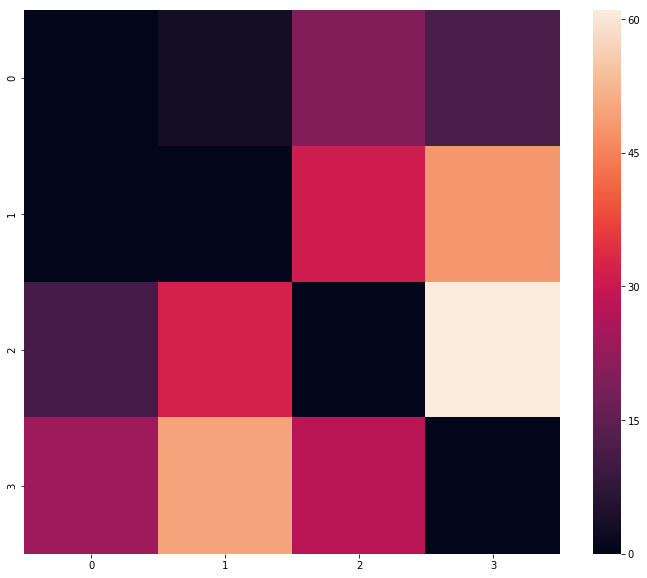

In [303]:
X_train_nerves_activity2, X_test_nerves_activity2, y_train_nerves_activity2, y_test_nerves_activity2 = train_test_split(data_nerves_activity_and_peak_values.drop(columns = 'label'), data_nerves_activity_and_peak_values['label'], test_size=0.33, random_state=42)
#X_train_nerves_activity=X_train_nerves_activity.values.reshape(-1, 1)
#X_test_nerves_activity=X_test_nerves_activity.values.reshape(-1, 1)



RFC_nerves_activity2 = RandomForestClassifier(bootstrap=False, max_features=6, n_estimators=1000, n_jobs=-1,random_state = 42)


pmp_RFC_nerves_activity2 = performance_meassure_pack(RFC_nerves_activity2,
                                                    X_train_nerves_activity2, X_test_nerves_activity2,
                                                    y_train_nerves_activity2, y_test_nerves_activity2 )
pmp_RFC_nerves_activity2.MultiClass_ErrorAnalysis_HeatMap()

In [305]:
pmp_RFC_nerves_activity2.conf_matrix

array([[928,   3,  20,  12],
       [  0, 912,  31,  48],
       [ 11,  32, 843,  61],
       [ 24,  50,  28, 851]], dtype=int64)

In [302]:
pmp_RFC_nerves_activity2.conf_matrix

array([[926,   2,  21,  14],
       [  1, 907,  35,  48],
       [ 10,  37, 842,  58],
       [ 26,  50,  30, 847]], dtype=int64)

In [300]:
pmp_RFC_nerves_activity2.conf_matrix

array([[904,   3,  33,  23],
       [  1, 857,  52,  81],
       [ 28,  37, 803,  79],
       [ 26,  78,  78, 771]], dtype=int64)

In [287]:
pmp_RFC_nerves_activity2.conf_matrix

array([[902,   4,  34,  23],
       [  1, 848,  56,  86],
       [ 32,  38, 800,  77],
       [ 28,  81,  85, 759]], dtype=int64)

In [312]:
pmp_RFC_nerves_activity2.conf_matrix[1,1]

912

# My scorer

In [335]:
def data_model_param_scorer_nestimators(data, estimators):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = 'label'), data['label'], test_size = 0.33)
    A,B,C,D = [], [],[],[]
    for i in estimators:
        RFC = RandomForestClassifier(bootstrap=False, max_features=6, n_estimators=i)
        RFC.fit(X_train, y_train)
        y_pred = RFC.predict(X_test)
        cf = confusion_matrix(y_test, y_pred)
        A.append(cf[0,0])
        B.append(cf[1,1])
        C.append(cf[2,2])
        D.append(cf[3,3])
   
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple estimators simultaneously",
              fontsize=16)



    plt.xlabel("Nr of estimators")
    plt.ylabel("Score")

    ax = plt.gca()

    X_axis = estimators
    ax.plot(X_axis, A)
    ax.plot(X_axis, B)
    ax.plot(X_axis, C)
    ax.plot(X_axis, D)
    
    plt.legend(loc="best")

No handles with labels found to put in legend.


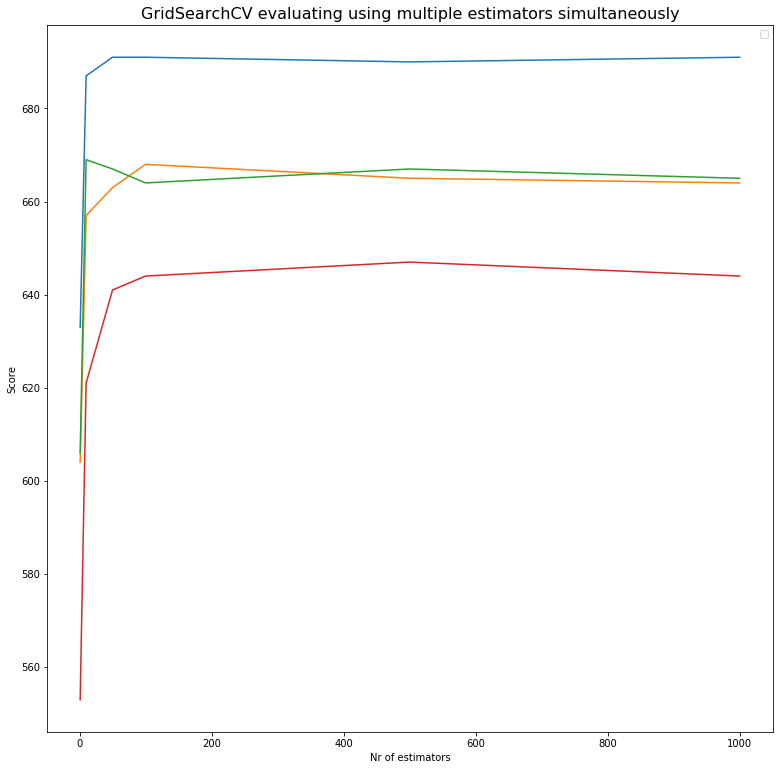

In [321]:
est = [1,10, 50, 100, 500, 1000]
data_model_param_scorer_nestimators(data = data_nerves_activity_and_peak_values, estimators=est)

In [334]:
def data_model_param_scorer_features(data, features, n):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = 'label'), data['label'], test_size=0.33)
    A,B,C,D = [], [],[],[]
    for i in features:
        RFC = RandomForestClassifier(bootstrap=False, max_features=i, n_estimators=n)
        RFC.fit(X_train, y_train)
        y_pred = RFC.predict(X_test)
        cf = confusion_matrix(y_test, y_pred)
        A.append(cf[0,0])
        B.append(cf[1,1])
        C.append(cf[2,2])
        D.append(cf[3,3])
   
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple features simultaneously",
              fontsize=16)



    plt.xlabel("Nr of features")
    plt.ylabel("Score")

    ax = plt.gca()

    X_axis = features
    ax.plot(X_axis, A)
    ax.plot(X_axis, B)
    ax.plot(X_axis, C)
    ax.plot(X_axis, D)
    
    plt.legend(loc="best")

No handles with labels found to put in legend.


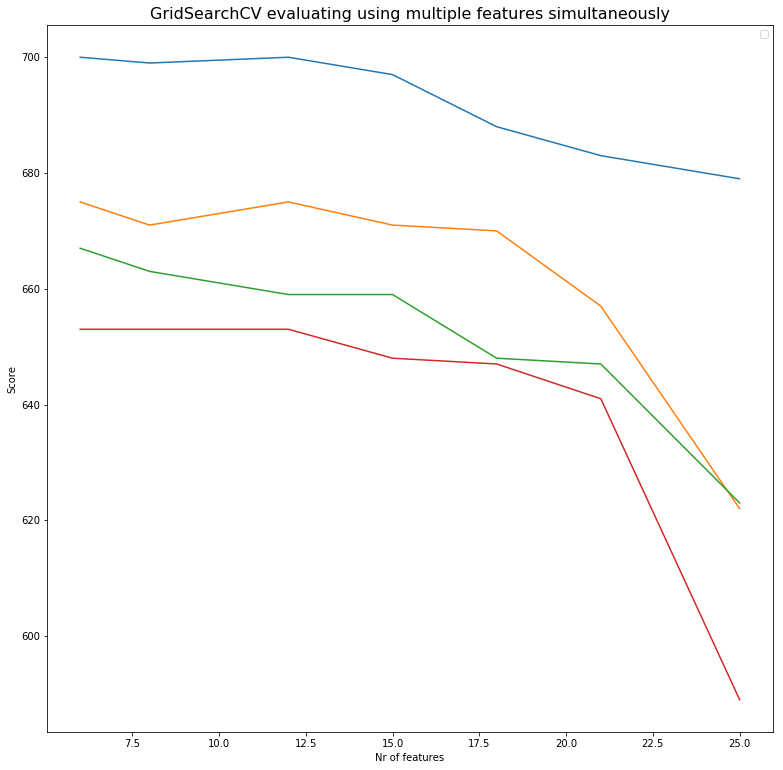

In [325]:
fea = [6,8,12,15,18,21,25]
data_model_param_scorer_features(data_nerves_activity_and_peak_values, features=fea, n =100)

No handles with labels found to put in legend.


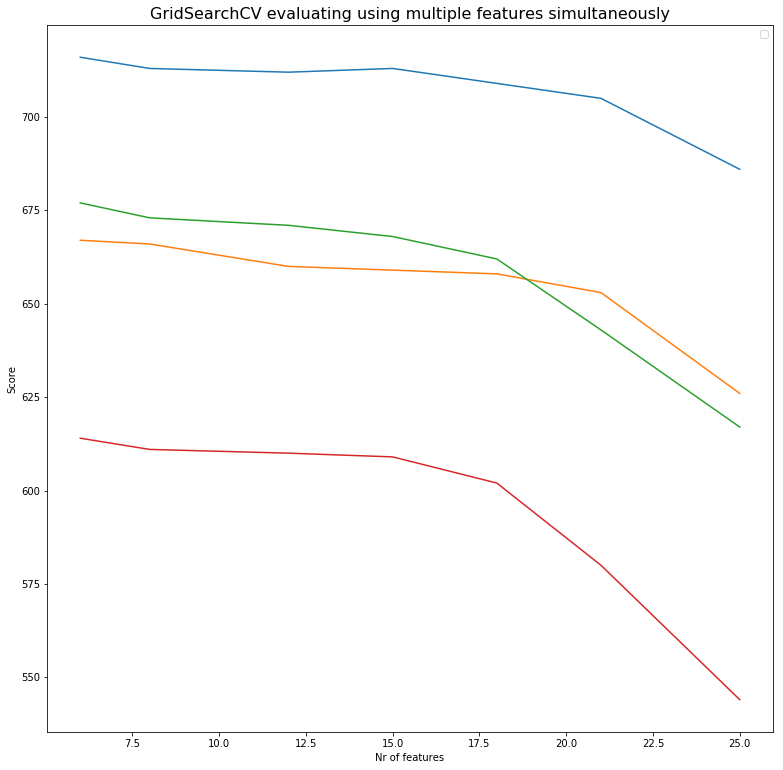

In [328]:
fea = [6,8,12,15,18,21,25]
data_model_param_scorer_features(data_nerves_activity_and_peak_values, features=fea, n =300)

No handles with labels found to put in legend.


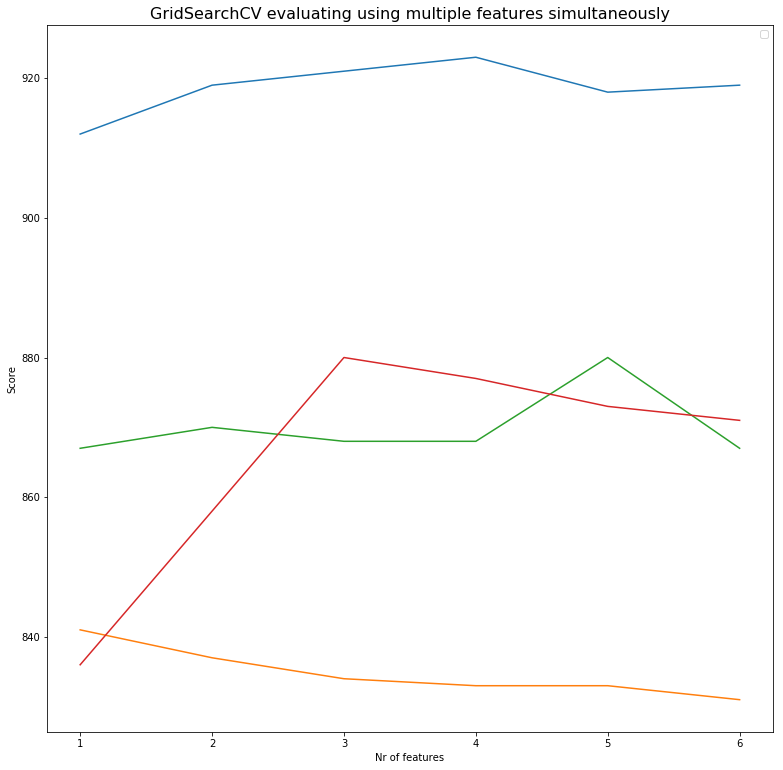

In [337]:
fea = [1,2,3,4,5,6]
data_model_param_scorer_features(data_nerves_activity_and_peak_values, features=fea, n =100)

No handles with labels found to put in legend.


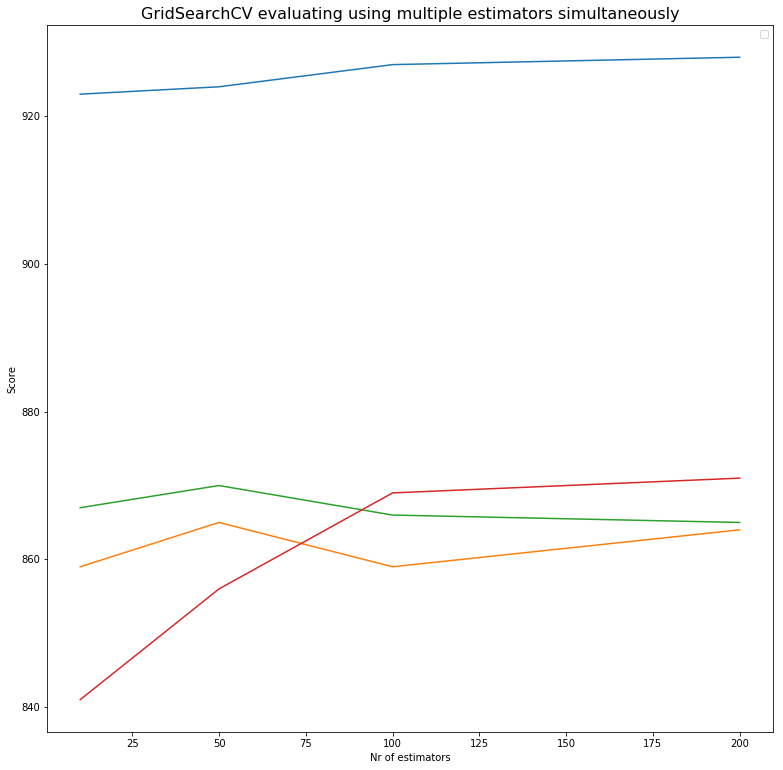

In [336]:
est = [10,50,100,200]
data_model_param_scorer_nestimators(data_nerves_activity_and_peak_values, estimators=est)

# Add feature - peak etc

In [374]:
data_newx = data_nerves_activity_and_peak_values.copy()
data_new =data_newx.drop(columns = ['label', 'nerve_activity'])

scaler = StandardScaler()
scaler.fit(data_new)
scaled_data_new = scaler.transform(data_new)
new_scaled = pd.DataFrame(data = scaled_data_new, columns = data_newx.columns[:-2])
new_scaled['label'] = data_nerves_activity_and_peak_values['label']
new_scaled['nerve_activity'] = data_nerves_activity_and_peak_values['nerve_activity']

X_train, X_test, y_train, y_test = train_test_split(new_scaled.drop(columns='label'),new_scaled['label'],
                                                    test_size=0.30)
kmeans = KMeans(n_clusters=300)

kmeans.fit(X_train)

nerve_activity_V2 = kmeans.labels_

pred_X_test = kmeans.predict(X_test)

X_train2 = X_train
X_train2['nerve_activity_V2'] = nerve_activity_V2
X_train2.drop(columns=['peak left slope value sensor S1', 'peak_position sensor S1',
       'peak_value sensor S1', 'peak left slope value sensor S2',
       'peak_position sensor S2', 'peak_value sensor S2',
       'peak left slope value sensor S3', 'peak_position sensor S3',
       'peak_value sensor S3', 'peak left slope value sensor S4',
       'peak_position sensor S4', 'peak_value sensor S4',
       'peak left slope value sensor S5', 'peak_position sensor S5',
       'peak_value sensor S5', 'peak left slope value sensor S6',
       'peak_position sensor S6', 'peak_value sensor S6',
       'peak left slope value sensor S7', 'peak_position sensor S7',
       'peak_value sensor S7', 'peak left slope value sensor S8',
       'peak_position sensor S8', 'peak_value sensor S8'], inplace = True)


X_test2 = X_test
X_test2['nerve_activity_V2'] = pred_X_test
X_test2.drop(columns=['peak left slope value sensor S1', 'peak_position sensor S1',
       'peak_value sensor S1', 'peak left slope value sensor S2',
       'peak_position sensor S2', 'peak_value sensor S2',
       'peak left slope value sensor S3', 'peak_position sensor S3',
       'peak_value sensor S3', 'peak left slope value sensor S4',
       'peak_position sensor S4', 'peak_value sensor S4',
       'peak left slope value sensor S5', 'peak_position sensor S5',
       'peak_value sensor S5', 'peak left slope value sensor S6',
       'peak_position sensor S6', 'peak_value sensor S6',
       'peak left slope value sensor S7', 'peak_position sensor S7',
       'peak_value sensor S7', 'peak left slope value sensor S8',
       'peak_position sensor S8', 'peak_value sensor S8'], inplace = True)

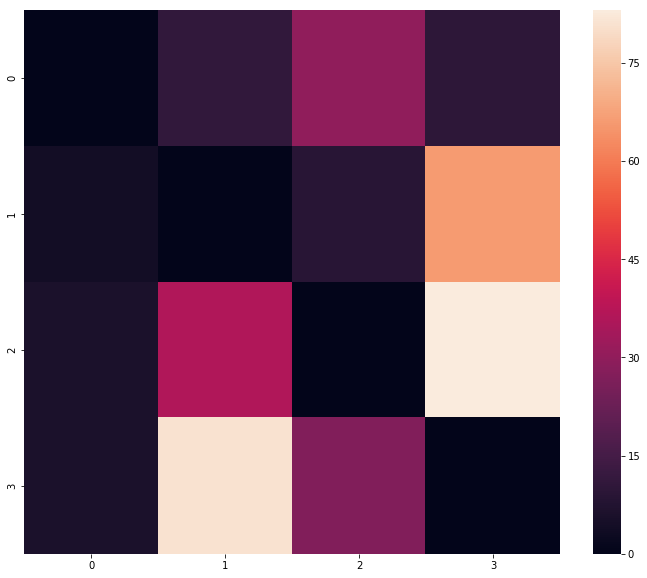

In [376]:
RFC_nerves_activity3 = RandomForestClassifier(bootstrap=False, n_estimators=100, n_jobs=-1,random_state = 42)


pmp_RFC_nerves_activity3 = performance_meassure_pack(RFC_nerves_activity3,
                                                    X_train2, X_test2,
                                                    y_train, y_test)
pmp_RFC_nerves_activity3.MultiClass_ErrorAnalysis_HeatMap()

In [ ]:
y_test()

In [377]:
pmp_RFC_nerves_activity3.conf_matrix

array([[806,  11,  30,  10],
       [  4, 795,   9,  66],
       [  6,  36, 759,  83],
       [  6,  81,  27, 775]], dtype=int64)

In [378]:
pmp_RFC_nerves_activity.conf_matrix

array([[932,   2,  24,   5],
       [  3, 885,  12,  91],
       [ 11,  30, 824,  82],
       [  6,  63,  20, 864]], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


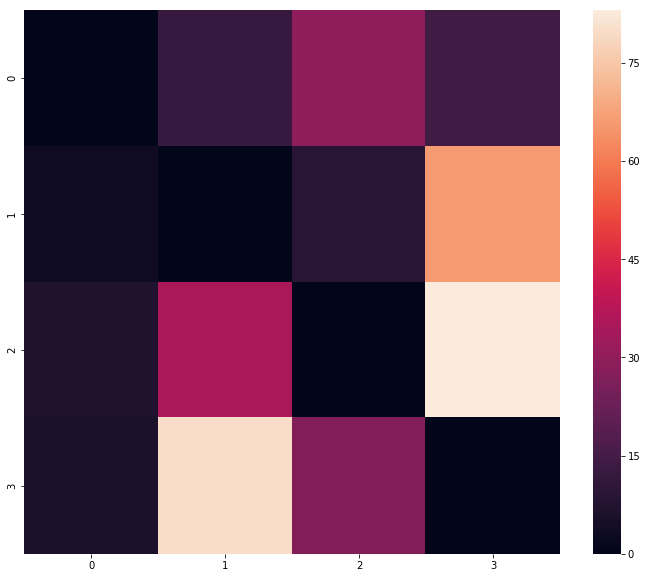

In [390]:
X_train2=scaler.fit_transform(X_train2)
X_test2= scaler.transform(X_test2)

SVC_clf = SVC(probability=True)

voting_clf2 = VotingClassifier(estimators=[('rf3', RFC_nerves_activity3), ('rf1', RFC_nerves_activity), ('svc', SVC_clf)],voting='soft')

pmp_voting2 = performance_meassure_pack(voting_clf2, X_train2, X_test2, y_train, y_test)
pmp_voting2.MultiClass_ErrorAnalysis_HeatMap()

In [391]:
pmp_voting2.conf_matrix

array([[801,  12,  30,  14],
       [  3, 796,   9,  66],
       [  7,  35, 759,  83],
       [  6,  80,  27, 776]], dtype=int64)

In [382]:
pmp_voting2.conf_matrix

array([[803,  11,  31,  12],
       [  4, 795,   9,  66],
       [  6,  35, 759,  84],
       [  4,  78,  29, 778]], dtype=int64)

In [383]:
pmp_RFC_nerves_activity3.conf_matrix

array([[806,  11,  30,  10],
       [  4, 795,   9,  66],
       [  6,  36, 759,  83],
       [  6,  81,  27, 775]], dtype=int64)



# Do Toolboxa
#data_c['dupa']=data.apply(lambda row: 0 if row.max() < 1 else 2, axis=1)
#data_c['dupa'] = data.apply(lambda row: row.max(), raw=False)
p = data_c.iloc[i,:][data_c.iloc[i, :] == sensor_peak_value[i]].first_valid_index()
data_cx=data_c.iloc[0,:]